<a href="https://colab.research.google.com/github/shatlykgurdov/3.1.2/blob/main/GWP1_12282.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Single example run (N = 200) ===
True b: 2.0
Full model b_hat: 1.9665
Omitted model b_hat: 4.1094

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     2172.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          6.08e-135
Time:                        13:02:06   Log-Likelihood:                -286.94
No. Observations:                 200   AIC:                             579.9
Df Residuals:                     197   BIC:                             589.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------

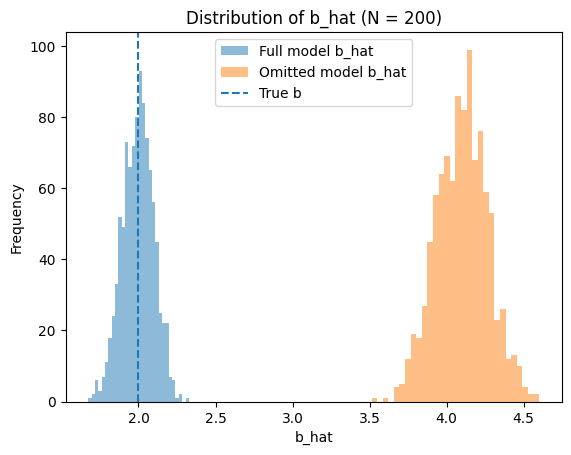

CLEAN DATA
Intercept: 4.992540020175753
Slope: 2.986927501643894
R2: 0.9886608393039376
MSE: 0.940051503155865

WITH OUTLIERS
Intercept: 8.253473768764092
Slope: 2.7563120990804264
R2: 0.4656737708639481
MSE: 80.0848205206974


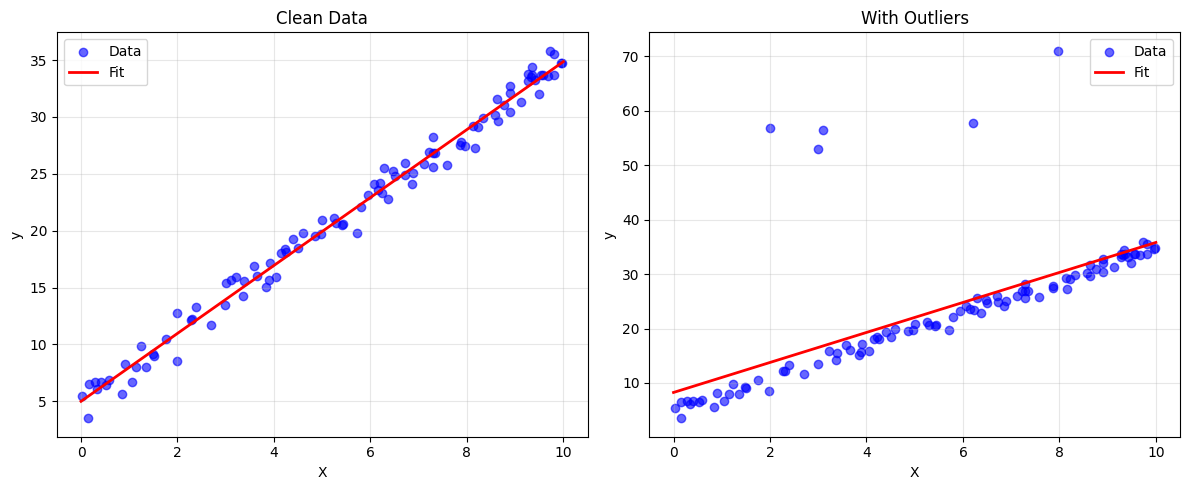


CLEAN DATA MODEL SUMMARY:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     8545.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):           3.82e-97
Time:                        13:02:09   Log-Likelihood:                -138.80
No. Observations:                 100   AIC:                             281.6
Df Residuals:                      98   BIC:                             286.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9925    

/tmp/ipython-input-964892658.py:425: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START, end=END, progress=False)


5b) Loaded 1509 daily closing prices for AAPL from 2018-01-02 to 2023-12-29


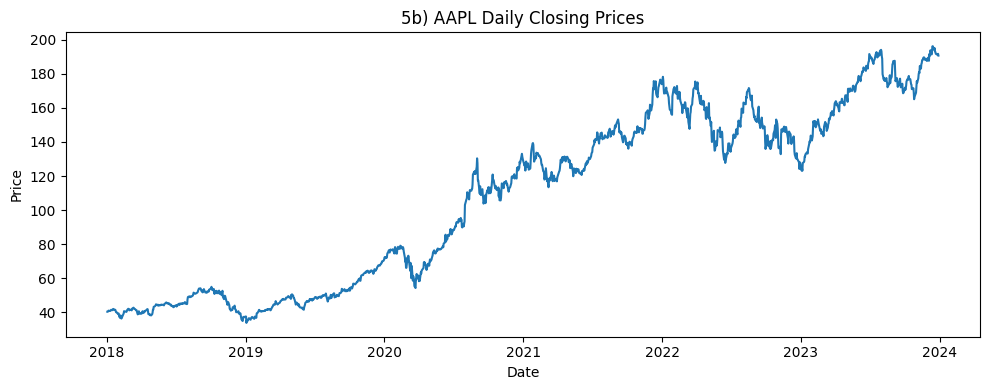


5b) ADF test on PRICE LEVELS
ADF statistic: -0.5118331518503599
p-value      : 0.8896865772854041
Used lags     : 1
N obs         : 1507
Critical vals : {'1%': np.float64(-3.434696697851678), '5%': np.float64(-2.8634597924260303), '10%': np.float64(-2.567792072971565)}
Conclusion (5%): Fail to reject H0 → consistent with a unit root (non-stationary).


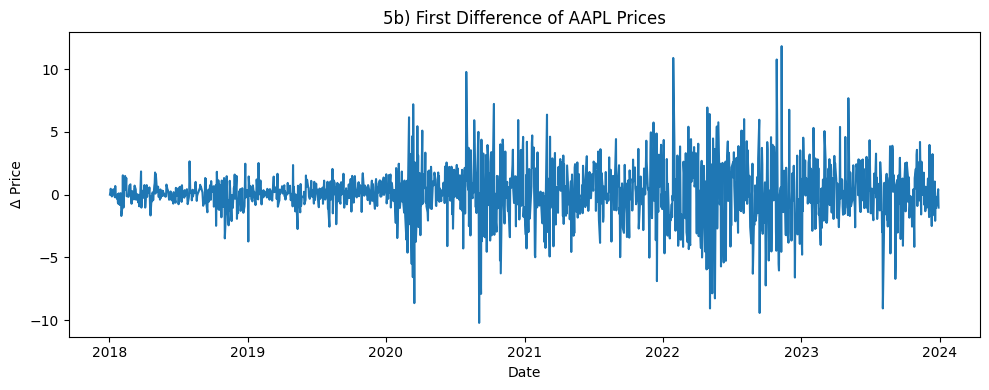


5b) ADF test on FIRST DIFFERENCES (ΔPrice)
ADF statistic: -40.3499105117573
p-value      : 0.0
Critical vals : {'1%': np.float64(-3.434696697851678), '5%': np.float64(-2.8634597924260303), '10%': np.float64(-2.567792072971565)}
Conclusion (5%): Reject H0 → differenced series is likely stationary.


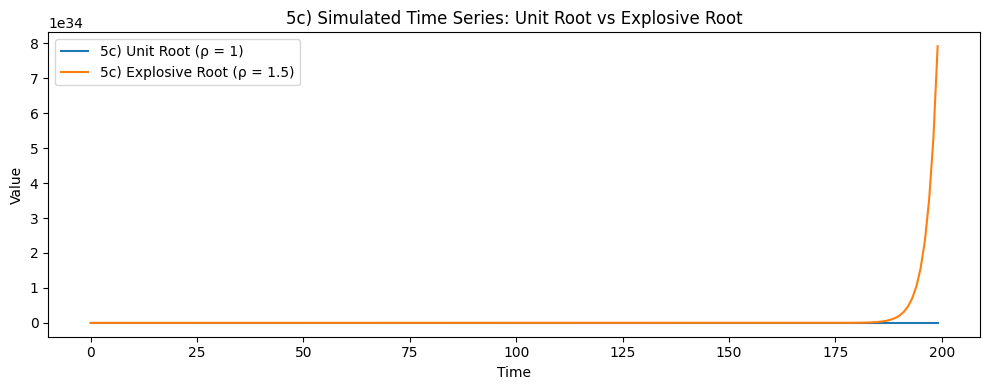

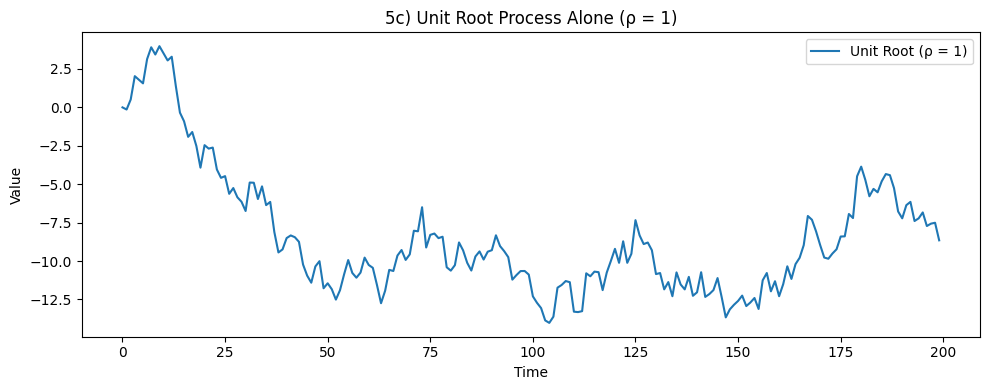


5c) Notes for interpretation:
- ρ = 1 (unit root) behaves like a random walk: shocks have permanent effects, series wanders but does not explode deterministically.
- ρ = 1.5 is explosive: values grow rapidly in magnitude, typically not resembling real financial/economic series over long samples.
- This is why unit roots are a key concern: they create non-stationarity without unrealistic explosive growth.


In [1]:
# Group 12282 GWP1
# -------------------------

# Common imports
# -------------------------
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.stattools import adfuller


# Problem 1d
# -----------------------------
# Settings & true parameters
# -----------------------------
np.random.seed(123)

a_true = 1.0
b_true = 2.0
c_true = 3.0
sigma_e = 1.0
rho = 0.7            # correlation between X and Z
sample_sizes = [50, 200, 1000]
n_sim = 1000         # number of simulations per sample size

# -----------------------------
# Helper: simulate once and estimate models
# -----------------------------
def simulate_once(N):
    """
    Simulate one dataset from:
        Y = a + b*X + c*Z + e
    where X and Z are correlated, then estimate:
      - Full model: Y ~ X + Z
      - Omitted model: Y ~ X
    Returns b_hat_full, b_hat_omit.
    """
    # Generate X
    X = np.random.normal(0, 1, size=N)
    # Generate noise for Z
    u = np.random.normal(0, 1, size=N)
    # Make Z correlated with X
    Z = rho * X + np.sqrt(1 - rho**2) * u
    # Error term
    e = np.random.normal(0, sigma_e, size=N)
    # True model
    Y = a_true + b_true * X + c_true * Z + e

    # Full model: Y ~ X + Z
    X_full = np.column_stack([X, Z])
    X_full = sm.add_constant(X_full)
    model_full = sm.OLS(Y, X_full).fit()
    b_hat_full = model_full.params[1]   # coefficient of X

    # Omitted model: Y ~ X
    X_omit = sm.add_constant(X)
    model_omit = sm.OLS(Y, X_omit).fit()
    b_hat_omit = model_omit.params[1]

    return b_hat_full, b_hat_omit, model_full, model_omit

# -----------------------------
# Part 1: Single example run
# -----------------------------
print("=== Single example run (N = 200) ===")
b_full, b_omit, model_full, model_omit = simulate_once(200)
print("True b:", b_true)
print("Full model b_hat:", round(b_full, 4))
print("Omitted model b_hat:", round(b_omit, 4))
print("\nFull model summary:")
print(model_full.summary())
print("\nOmitted model summary:")
print(model_omit.summary())

# -----------------------------
# Part 2: Many simulations to study bias & variance
# -----------------------------
results = {}

for N in sample_sizes:
    b_full_list = []
    b_omit_list = []

    for _ in range(n_sim):
        b_f, b_o, _, _ = simulate_once(N)
        b_full_list.append(b_f)
        b_omit_list.append(b_o)

    results[N] = {
        "b_full_mean": np.mean(b_full_list),
        "b_full_std": np.std(b_full_list),
        "b_omit_mean": np.mean(b_omit_list),
        "b_omit_std": np.std(b_omit_list),
        "b_full_list": b_full_list,
        "b_omit_list": b_omit_list,
    }

# Print summary statistics
print("\n=== Simulation summary over", n_sim, "runs ===")
print("True b:", b_true)

for N in sample_sizes:
    print(f"\nSample size N = {N}")
    print("Full model:   mean(b_hat) =",
          round(results[N]["b_full_mean"], 3),
          ", std(b_hat) =",
          round(results[N]["b_full_std"], 3))
    print("Omitted model: mean(b_hat) =",
          round(results[N]["b_omit_mean"], 3),
          ", std(b_hat) =",
          round(results[N]["b_omit_std"], 3))

# -----------------------------
# Part 3: Plot distribution for one N
# -----------------------------
N_plot = 200   # choose which N to visualize
b_full_list = results[N_plot]["b_full_list"]
b_omit_list = results[N_plot]["b_omit_list"]

plt.hist(b_full_list, bins=30, alpha=0.5, label="Full model b_hat")
plt.hist(b_omit_list, bins=30, alpha=0.5, label="Omitted model b_hat")
plt.axvline(b_true, linestyle="--", label="True b")
plt.title(f"Distribution of b_hat (N = {N_plot})")
plt.xlabel("b_hat")
plt.ylabel("Frequency")
plt.legend()
plt.show()



# GWP1 Problem 2b

rng = np.random.default_rng(0)

# 1) Generate clean linear data
n_samples = 100
X = rng.uniform(0, 10, size=(n_samples, 1))
noise = rng.normal(0, 1, size=n_samples)
y = 3 * X.ravel() + 5 + noise # true slope = 3, intercept = 5

# Fit linear regression on clean data
lin_clean = LinearRegression()
lin_clean.fit(X, y)
y_pred_clean = lin_clean.predict(X)

print("CLEAN DATA")
print("Intercept:", lin_clean.intercept_)
print("Slope:", lin_clean.coef_[0])
print("R2:", r2_score(y, y_pred_clean))
print("MSE:", mean_squared_error(y, y_pred_clean))

# 2) Make a copy and inject outliers
X_out = X.copy()
y_out = y.copy()

n_outliers = 5
idx = rng.choice(n_samples, size=n_outliers, replace=False)

# Extreme y-values at existing X
y_out[idx] = y_out[idx] + rng.normal(40, 5, size=n_outliers)

# Fit linear regression on contaminated data
lin_out = LinearRegression()
lin_out.fit(X_out, y_out)
y_pred_out = lin_out.predict(X_out)

print("\nWITH OUTLIERS")
print("Intercept:", lin_out.intercept_)
print("Slope:", lin_out.coef_[0])
print("R2:", r2_score(y_out, y_pred_out))
print("MSE:", mean_squared_error(y_out, y_pred_out))

import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Clean data plot
ax1.scatter(X, y, alpha=0.6, color='blue', label='Data')
x_range = np.linspace(0, 10, 100).reshape(-1, 1)
ax1.plot(x_range, lin_clean.predict(x_range), color='red', linewidth=2, label='Fit')
ax1.set_title('Clean Data')
ax1.set_xlabel('X')
ax1.set_ylabel('y')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Outlier data plot
ax2.scatter(X_out, y_out, alpha=0.6, color='blue', label='Data')
ax2.plot(x_range, lin_out.predict(x_range), color='red', linewidth=2, label='Fit')
ax2.set_title('With Outliers')
ax2.set_xlabel('X')
ax2.set_ylabel('y')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

import statsmodels.api as sm

# Clean data model with significance
X_clean_sm = sm.add_constant(X)  # Adds intercept column
model_clean = sm.OLS(y, X_clean_sm).fit()
print("\nCLEAN DATA MODEL SUMMARY:")
print(model_clean.summary())

# Outlier data model with significance
X_out_sm = sm.add_constant(X_out)
model_out = sm.OLS(y_out, X_out_sm).fit()
print("\nOUTLIER DATA MODEL SUMMARY:")
print(model_out.summary())




# Problem 3a – Model Selection for Y ~ Z1, Z2, Z3, Z4, Z5
# Group 12282 (even) → FE-GWP1_model_selection_2.csv

# =========================
# 1. Load the dataset
# =========================
df = pd.read_csv("FE-GWP1_model_selection_2.csv")

# Clean column names: remove leading/trailing spaces
df.columns = df.columns.str.strip()

print("First 5 rows of dataset:")
print(df.head())
print("\nColumns in dataset:", df.columns.tolist())

# Now columns should be: 'Y', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5'
y = df["Y"]
X_all = df[["Z1", "Z2", "Z3", "Z4", "Z5"]]
candidate_predictors = list(X_all.columns)

# Helper function to fit OLS model with given predictors
def fit_model(predictors):
    X = sm.add_constant(X_all[list(predictors)])
    model = sm.OLS(y, X).fit()
    return model

# =========================
# 2. Approach 1: All-subsets model selection
#    (Adjusted R², AIC, BIC)
# =========================
results = []

for k in range(1, len(candidate_predictors) + 1):
    for subset in itertools.combinations(candidate_predictors, k):
        model = fit_model(subset)
        results.append({
            "predictors": subset,
            "adj_R2": model.rsquared_adj,
            "AIC": model.aic,
            "BIC": model.bic
        })

results_df = pd.DataFrame(results)

# Top models by each criterion
best_by_adjR2 = results_df.sort_values("adj_R2", ascending=False).head(5)
best_by_AIC   = results_df.sort_values("AIC", ascending=True).head(5)
best_by_BIC   = results_df.sort_values("BIC", ascending=True).head(5)

print("\n=== Top 5 models by Adjusted R² ===")
print(best_by_adjR2)

print("\n=== Top 5 models by AIC ===")
print(best_by_AIC)

print("\n=== Top 5 models by BIC ===")
print(best_by_BIC)

# Choose one "best" model by BIC
best_model_row = best_by_BIC.iloc[0]
best_predictors = list(best_model_row["predictors"])
print("\n>>> Chosen best model by BIC has predictors:", best_predictors)

best_model = fit_model(best_predictors)
print("\n=== Summary of best model by BIC ===")
print(best_model.summary())

# =========================
# 3. Approach 2: Forward stepwise selection (AIC)
# =========================
def forward_stepwise_selection(X, y, verbose=True):
    remaining = list(X.columns)
    selected = []
    current_score = np.inf
    best_new_score = np.inf

    while remaining:
        scores_with_candidates = []

        for candidate in remaining:
            predictors = selected + [candidate]
            X_candidate = sm.add_constant(X[predictors])
            model = sm.OLS(y, X_candidate).fit()
            scores_with_candidates.append((model.aic, candidate))

        # Pick candidate with lowest AIC
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]

        if verbose:
            print(f"Trying to add {best_candidate}: AIC = {best_new_score:.3f}")

        if best_new_score < current_score - 1e-6:  # improvement
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            if verbose:
                print(f"  -> Added {best_candidate}, new AIC = {current_score:.3f}")
        else:
            if verbose:
                print("No further AIC improvement. Stopping forward selection.")
            break

    return selected, current_score

print("\n=== Forward Stepwise Selection (AIC) ===")
forward_predictors, forward_aic = forward_stepwise_selection(X_all, y, verbose=True)
print("\n>>> Forward stepwise selected predictors:", forward_predictors)
print("Final AIC from forward selection:", forward_aic)

X_forward = sm.add_constant(X_all[forward_predictors])
forward_model = sm.OLS(y, X_forward).fit()
print("\n=== Summary of forward stepwise model ===")
print(forward_model.summary())

# =========================
# 4. Approach 3: Backward elimination (BIC)
# =========================
def backward_elimination(X, y, verbose=True, criterion="BIC"):
    predictors = list(X.columns)

    # Start with full model
    X_full = sm.add_constant(X[predictors])
    model_full = sm.OLS(y, X_full).fit()
    if criterion == "AIC":
        best_score = model_full.aic
    elif criterion == "BIC":
        best_score = model_full.bic
    else:
        raise ValueError("criterion must be 'AIC' or 'BIC'")

    if verbose:
        print(f"\nStart backward elimination with full model {predictors}, {criterion} = {best_score:.3f}")

    improved = True
    while improved and len(predictors) > 1:
        scores_with_candidates = []

        for candidate in predictors:
            trial_predictors = [p for p in predictors if p != candidate]
            X_trial = sm.add_constant(X[trial_predictors])
            trial_model = sm.OLS(y, X_trial).fit()
            score = trial_model.aic if criterion == "AIC" else trial_model.bic
            scores_with_candidates.append((score, candidate, trial_predictors))

        scores_with_candidates.sort()
        best_new_score, worst_predictor, best_predictor_set = scores_with_candidates[0]

        if verbose:
            print(f"Trying to remove {worst_predictor}: {criterion} = {best_new_score:.3f}")

        if best_new_score < best_score - 1e-6:
            predictors = best_predictor_set
            best_score = best_new_score
            if verbose:
                print(f"  -> Removed {worst_predictor}, new {criterion} = {best_score:.3f}")
        else:
            if verbose:
                print("No further improvement. Stopping backward elimination.")
            improved = False

    final_X = sm.add_constant(X[predictors])
    final_model = sm.OLS(y, final_X).fit()
    return predictors, best_score, final_model

print("\n=== Backward Elimination (BIC) ===")
backward_predictors, backward_score, backward_model = backward_elimination(X_all, y, verbose=True, criterion="BIC")
print("\n>>> Backward elimination (BIC) selected predictors:", backward_predictors)
print("Final BIC from backward elimination:", backward_score)
print("\n=== Summary of backward elimination model ===")
print(backward_model.summary())

# =========================
# 5. Final comparison info
# =========================
print("\n================ FINAL SUMMARY ================")
print("Best model by BIC (all-subsets) predictors:", best_predictors)
print("Forward stepwise selected predictors:", forward_predictors)
print("Backward elimination (BIC) selected predictors:", backward_predictors)
print("Use these results to justify your final chosen model in the report.")



# ============================================================
# GWP1 — Problem 5b and 5c
# ============================================================

# ============================================================
# 5b) Use real economic data for equities and illustrate if the
#     time series you chose has a unit root.
# ============================================================

# ---- 5b.1: Load real equity price data ----
# Option A : use yfinance (works in Colab / many environments)
# If yfinance is not installed, uncomment the next line:
# !pip -q install yfinance


TICKER = "AAPL"            # change if you want: "MSFT", "^GSPC" (S&P500), "TSLA", etc.
START = "2018-01-01"
END   = "2024-01-01"

data = yf.download(TICKER, start=START, end=END, progress=False)
prices = data["Close"].dropna()

print(f"5b) Loaded {len(prices)} daily closing prices for {TICKER} from {prices.index.min().date()} to {prices.index.max().date()}")

# ---- 5b.2: Plot the price series ----
plt.figure(figsize=(10, 4))
plt.plot(prices)
plt.title(f"5b) {TICKER} Daily Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

# ---- 5b.3: Run ADF test on levels (prices) ----
# H0: unit root (non-stationary)
# H1: stationary
adf_levels = adfuller(prices, autolag="AIC")

print("\n5b) ADF test on PRICE LEVELS")
print("ADF statistic:", adf_levels[0])
print("p-value      :", adf_levels[1])
print("Used lags     :", adf_levels[2])
print("N obs         :", adf_levels[3])
print("Critical vals :", adf_levels[4])

if adf_levels[1] < 0.05:
    print("Conclusion (5%): Reject H0 → evidence against unit root (stationary).")
else:
    print("Conclusion (5%): Fail to reject H0 → consistent with a unit root (non-stationary).")

# ---- 5b.4 (optional but very helpful): show that first differences are usually stationary ----
returns_diff = prices.diff().dropna()  # first difference of price (not log returns)
adf_diff = adfuller(returns_diff, autolag="AIC")

plt.figure(figsize=(10, 4))
plt.plot(returns_diff)
plt.title(f"5b) First Difference of {TICKER} Prices")
plt.xlabel("Date")
plt.ylabel("Δ Price")
plt.tight_layout()
plt.show()

print("\n5b) ADF test on FIRST DIFFERENCES (ΔPrice)")
print("ADF statistic:", adf_diff[0])
print("p-value      :", adf_diff[1])
print("Critical vals :", adf_diff[4])

if adf_diff[1] < 0.05:
    print("Conclusion (5%): Reject H0 → differenced series is likely stationary.")
else:
    print("Conclusion (5%): Fail to reject H0 → differenced series may still be non-stationary.")

# ============================================================
# 5c) Why are we concerned about a unit root (ρ=1) and not a
#     root of 1.5? Use simulations to compare the two.
# ============================================================

np.random.seed(42)

# ---- 5c.1: Simulation settings ----
T = 200                # number of time points
sigma_eps = 1.0        # shock volatility

# Unit root (random walk): y_t = y_{t-1} + eps_t   (ρ = 1)
rho_unit = 1.0

# Explosive root: y_t = ρ y_{t-1} + eps_t          (ρ = 1.5)
rho_explosive = 1.5

eps = np.random.normal(0, sigma_eps, size=T)

# ---- 5c.2: Generate the two processes ----
y_unit = np.zeros(T)
y_explosive = np.zeros(T)

for t in range(1, T):
    y_unit[t] = rho_unit * y_unit[t-1] + eps[t]         # random walk
    y_explosive[t] = rho_explosive * y_explosive[t-1] + eps[t]  # explosive

# ---- 5c.3: Plot both series for visual comparison ----
plt.figure(figsize=(10, 4))
plt.plot(y_unit, label="5c) Unit Root (ρ = 1)")
plt.plot(y_explosive, label="5c) Explosive Root (ρ = 1.5)")
plt.title("5c) Simulated Time Series: Unit Root vs Explosive Root")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# ---- 5c.4:  plot: same plot but with y-axis limits for unit root ----
# This helps show how explosive series quickly dominates the scale.
plt.figure(figsize=(10, 4))
plt.plot(y_unit, label="Unit Root (ρ = 1)")
plt.title("5c) Unit Root Process Alone (ρ = 1)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

print("\n5c) Notes for interpretation:")
print("- ρ = 1 (unit root) behaves like a random walk: shocks have permanent effects, series wanders but does not explode deterministically.")
print("- ρ = 1.5 is explosive: values grow rapidly in magnitude, typically not resembling real financial/economic series over long samples.")
print("- This is why unit roots are a key concern: they create non-stationarity without unrealistic explosive growth.")


